# Modelos mejorados

En esta sección se mostrarán los resultados del entrenamiento de modelos con técnicas de *ensemble*, específicamente, *bagging*, *voting* y *stacking*. Aprovechando los resultados de la sección previa, las hiperparametrizaciones correspondientes se realizaron centrándose en los parámetros más óptimos, con una menor cantidad de iteraciones para el `BayesSearchCV`. 

## Contenidos

1. [Bagging](#Bagging)
2. [Voting](#Voting)
3. [Stacking](#Stacking)
4. [Comparación de modelos](#Comparacion-de-modelos)

Importación de librerías y modelos base para comparación.

In [1]:
# Importación de librerías
import os
import sys
from pickle import load, UnpicklingError

from pandas import DataFrame, concat
from numpy import array

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from skopt.space import Real, Integer, Categorical

proyect = os.path.abspath('../..')
if proyect not in sys.path:
    sys.path.append(proyect)
from Improved.models_testing import evaluate_model, plot_confusion_matrix, plot_predictions, plot_roc_curve, plot_feature_importances, get_predictions

In [2]:
with open('../../Models/model_list.txt', 'r') as file:
    model_filenames = file.read().splitlines()

models = []
for model_name in model_filenames:
    model_path = os.path.join('../../Models', f'{model_name}.pkl')
    print(f"Attempting to load model from: {model_path}")
    if os.path.exists(model_path):
        try:
            with open(model_path, 'rb') as model_file:
                model = load(model_file)
                models.append(model)
                print(f"Successfully loaded model: {model_name}")
        except (UnpicklingError, EOFError, OSError, Exception) as e:
            print(f"Error loading {model_path}: {e}")
    else:
        print(f"File {model_path} does not exist.")

Attempting to load model from: ../../Models\Logistic Base.pkl
Successfully loaded model: Logistic Base
Attempting to load model from: ../../Models\Logistic Balanced.pkl
Successfully loaded model: Logistic Balanced
Attempting to load model from: ../../Models\Logistic PCA Base.pkl
Successfully loaded model: Logistic PCA Base
Attempting to load model from: ../../Models\Logistic PCA Balanced.pkl
Successfully loaded model: Logistic PCA Balanced
Attempting to load model from: ../../Models\KNN Base.pkl
Successfully loaded model: KNN Base
Attempting to load model from: ../../Models\KNN Balanced.pkl
Successfully loaded model: KNN Balanced
Attempting to load model from: ../../Models\KNN PCA Base.pkl
Successfully loaded model: KNN PCA Base
Attempting to load model from: ../../Models\KNN PCA Balanced.pkl
Successfully loaded model: KNN PCA Balanced
Attempting to load model from: ../../Models\Descicion Tree Base.pkl
Successfully loaded model: Descicion Tree Base
Attempting to load model from: ../../

In [3]:
with open( '../../Models/data_models.pkl', 'rb' ) as f:
    data = load( f )
X_test, y_test = data['train']
X_test, y_test = X_test.copy(), y_test.copy()

## Bagging

*Bagging* es una técnica de ensamblaje en la que se entrenan varios modelos sobre las muestras bootstrap, y se toman en cuenta todas las predicciones a modo de votación para predecir la clase final.

Para cada tipo de modelo, se seleccionó la adición de reducción de dimensionalidad por PCA según el impacto que tuviera en el puntaje final del modelo. Dado el buen desempeño de los modelos $k$-NN con y sin PCA, se entrenarán estos dos en simultáneo.

Importación de modelos.

In [4]:
with open('../../Improved/Bagging/bagging_list.txt', 'r') as file:
    bagging_model_filenames = file.read().splitlines()

bagging_models = []
for model_name in bagging_model_filenames:
    model_path = os.path.join('../../Improved/Bagging', f'{model_name}.pkl')
    print(f"Attempting to load model from: {model_path}")
    if os.path.exists(model_path):
        try:
            with open(model_path, 'rb') as model_file:
                model = load(model_file)
                bagging_models.append(model)
                print(f"Successfully loaded model: {model_name}")
        except (UnpicklingError, EOFError, OSError, Exception) as e:
            print(f"Error loading {model_path}: {e}")
    else:
        print(f"File {model_path} does not exist.")

Attempting to load model from: ../../Improved/Bagging\Bayes Bagging Balanced.pkl
Successfully loaded model: Bayes Bagging Balanced
Attempting to load model from: ../../Improved/Bagging\Bayes Bagging Base.pkl
Successfully loaded model: Bayes Bagging Base
Attempting to load model from: ../../Improved/Bagging\Descicion Tree Bagging Balanced.pkl
Successfully loaded model: Descicion Tree Bagging Balanced
Attempting to load model from: ../../Improved/Bagging\Descicion Tree Bagging Base.pkl
Successfully loaded model: Descicion Tree Bagging Base
Attempting to load model from: ../../Improved/Bagging\KNN Bagging Balanced.pkl
Successfully loaded model: KNN Bagging Balanced
Attempting to load model from: ../../Improved/Bagging\KNN Bagging Base.pkl
Successfully loaded model: KNN Bagging Base
Attempting to load model from: ../../Improved/Bagging\KNN Bagging PCA Balanced.pkl
Successfully loaded model: KNN Bagging PCA Balanced
Attempting to load model from: ../../Improved/Bagging\KNN Bagging PCA Base.

### $k$ Nearest Neighbors

Como se menciona antes, para el caso de los modelos $k$-NN, se usaron ambos preprocesamientos de los datos dado el desempeño de los modelos en ambos casos. La generación de los modelos es la siguiente:

In [5]:
knn_bagg = {
    'name': 'KNN Bagging',
    'pipe': Pipeline([
        ('scaler', StandardScaler()),
        ('bagging', BaggingClassifier( 
                estimator = KNeighborsClassifier(),
                max_samples=0.3,
                random_state = 37
            ) )
    ]),
    'search_spaces': {
        'bagging__n_estimators': Integer( 5, 30 ),
        'bagging__estimator__n_neighbors': Integer( 10, 70 ),
        'bagging__estimator__weights': Categorical( [ 'uniform', 'distance' ] )
    }
}

knn_bagg_pca = {
    'name': 'KNN Bagging PCA',
    'pipe': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(0.9)),
        ('bagging', BaggingClassifier( 
                estimator = KNeighborsClassifier(),
                max_samples=0.3,
                random_state = 37
            ) )
    ]),
    'search_spaces': {
        'bagging__n_estimators': Integer( 5, 30 ),
        'bagging__estimator__n_neighbors': Integer( 10, 70 ),
        'bagging__estimator__weights': Categorical( [ 'uniform', 'distance' ] )
    }
}

Resultados de los modelos $k$-NN:

In [6]:
knn_models = models[ 4:8 ]
parameters = [ 
        { 'Nombre': model_filenames[ 4 + i ] } | 
        model['model'].best_params_ | 
        { 'AUC': model['model'].best_score_, 'Tiempo de CPU': model['cpu_time'] } 
    for i, model in enumerate(knn_models) 

]
parameters = DataFrame( parameters )
parameters

,Nombre,classifier__n_neighbors,classifier__weights,AUC,Tiempo de CPU
0,KNN Base,59,uniform,0.742910,1925.500179
1,KNN Balanced,53,distance,0.753952,942.796789
2,KNN PCA Base,55,uniform,0.741183,437.227390
3,KNN PCA Balanced,37,distance,0.750647,359.124776


Resultados de los modelos $k$-NN con bagging:

In [7]:
knn_models = bagging_models[ 4:8 ]
parameters = [ 
        { 'Nombre': model_filenames[ 4 + i ] } | 
        model['model'].best_params_ | 
        { 'AUC': model['model'].best_score_, 'Tiempo de CPU': model['cpu_time'] } 
    for i, model in enumerate(knn_models) 

]
parameters = DataFrame( parameters )
parameters

,Nombre,bagging__estimator__n_neighbors,bagging__estimator__weights,bagging__n_estimators,AUC,Tiempo de CPU
0,KNN Base,12,distance,15,0.753896,445.296643
1,KNN Balanced,20,distance,14,0.745889,1449.879107
2,KNN PCA Base,43,distance,14,0.745851,195.611159
3,KNN PCA Balanced,45,distance,24,0.743430,786.976059


A diferencia del caso anterior, no hay ima relación tan estricta entre la dimensionalidad de los datos y el tiempo en CPU. Por otro lado, se puede ver que se tuvo un desempeño similar a los modelos sin bagging aplicado, con la particularidad que todos optaron por aplicar pesos a la votación interna de acuerdo a la distancia. Por otro lado, en comparación con los modelos base, los modelos con bagging, usaron menos vecinos para la predicción. Los resultados de los modelos se ven a continuación:

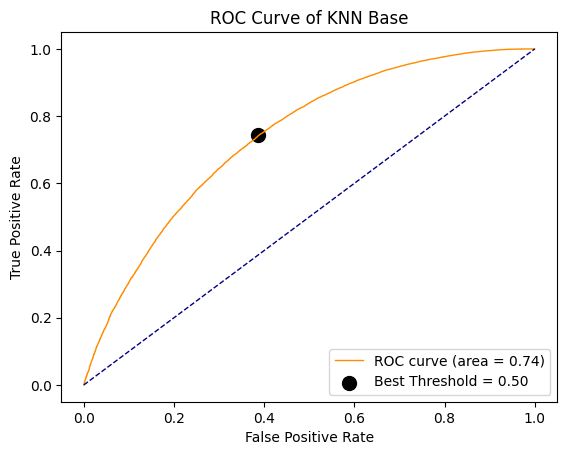

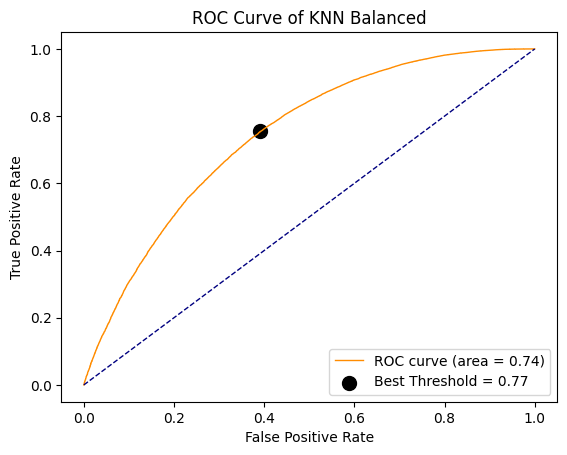

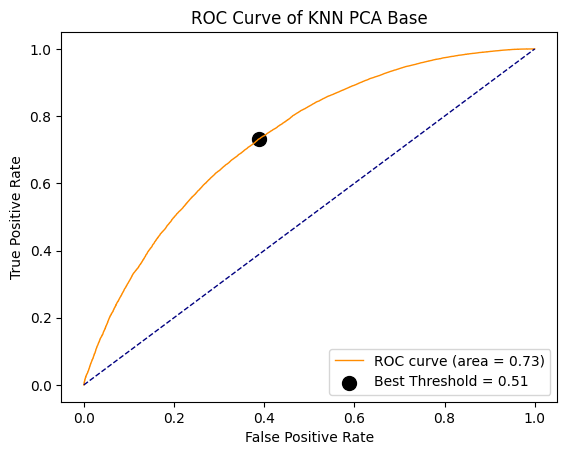

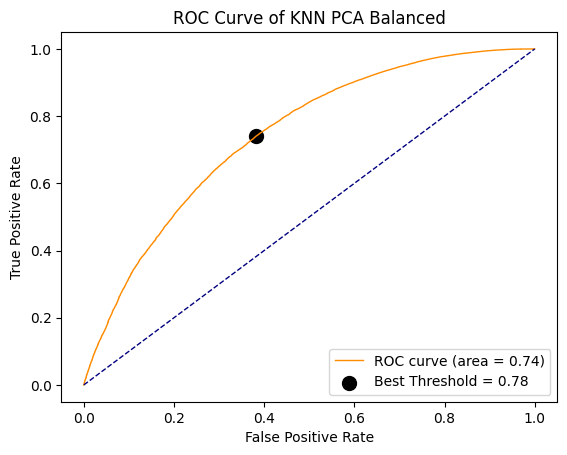

In [23]:
for idx, row in parameters.iterrows():
    model = bagging_models[ 4 + idx ]['model']
    model_name = row['Nombre']
    plot_roc_curve(model, X_test, y_test, model_name)

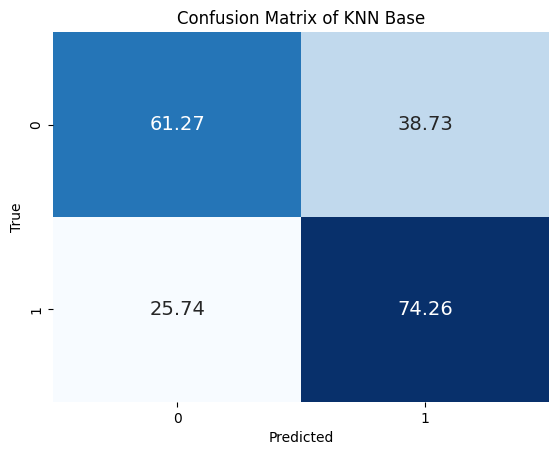

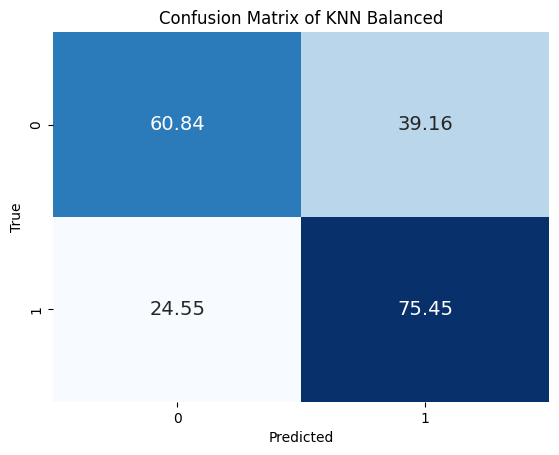

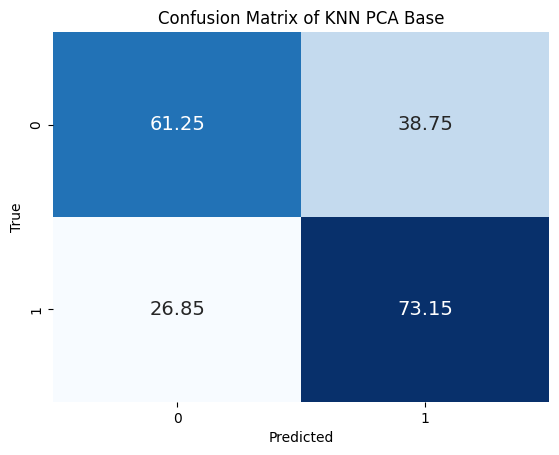

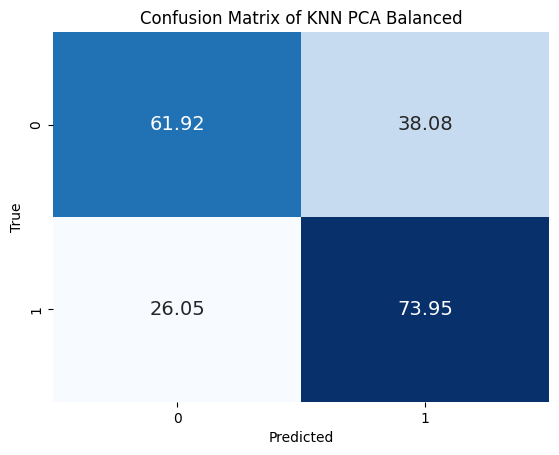

In [24]:
for idx, row in parameters.iterrows():
    model = bagging_models[ 4 + idx ]['model']
    model_name = row['Nombre']
    plot_confusion_matrix(model, X_test, y_test, model_name)

Como era de esperarse por los resultados anteriores, la aplicación de bagging en este modelo no influyó de manera significativa en el desempeño de este. Finalmente podemos ver una tabla con los resultados de la evaluación de los modelos:

In [20]:
results = []

for idx, model_info in enumerate(models[4:8]):
    model = model_info['model']
    name = model_info['name'] + (' Balanced' if idx % 2 == 1 else ' Base')
    cpu_time = model_info['cpu_time']
    
    evaluation = evaluate_model(model, X_test, y_test)
    evaluation['Name'] = name
    evaluation['CPU Time'] = cpu_time
    
    results.append(evaluation)

for idx, model_info in enumerate(bagging_models[4:8]):
    model = model_info['model']
    name = model_info['name'] + (' Balanced' if idx % 2 == 1 else ' Base')
    cpu_time = model_info['cpu_time']
    
    evaluation = evaluate_model(model, X_test, y_test)
    evaluation['Name'] = name
    evaluation['CPU Time'] = cpu_time
    
    results.append(evaluation)

df_results = DataFrame(results)
df_results

,Precision,Recall,F1,AUC,Name,CPU Time
0,0.860359,0.754021,0.803688,0.739825,KNN Base,1925.500179
1,0.859890,0.747051,0.799509,0.735952,KNN Balanced,942.796789
2,0.861501,0.750122,0.801963,0.740496,KNN PCA Base,437.227390
3,0.864612,0.724856,0.788590,0.736895,KNN PCA Balanced,359.124776
4,0.861577,0.742612,0.797683,0.740347,KNN Bagging Base,445.296643
5,0.862165,0.754528,0.804763,0.743366,KNN Bagging Balanced,1449.879107
6,0.859736,0.731506,0.790454,0.734961,KNN Bagging PCA Base,195.611159
7,0.863109,0.739489,0.796531,0.742572,KNN Bagging PCA Balanced,786.976059


De la tabla podemos ver que el puntaje máximo entre los modelos $k$-NN aumentó ligeramente con el último de los modelos presentados, con un score AUC 0.002 puntos mayor que el mejor modelo base. Aún así, estas mejoría se obtuvo a costa de un tiempo de entrenamiento 2 veces mayor que el anterior.

### Clasificación bayesiana

Es de esperarse que este sea el modelo con peor desempeño entre los nuevos modelos de ensamblaje, dado el desempeño previo, aún así, se espera mejorar un poco ese puntaje por medio del bagging. La declaración del modelo es la siguiente.

In [ ]:

bayes_bagg = {
    'name': 'Bayes Bagging',
    'pipe': Pipeline([
        ('scaler', StandardScaler()),
        ('bagging', BaggingClassifier( 
                estimator = BernoulliNB(),
                random_state = 37
            ) )
    ]),
    'search_spaces': {
        'bagging__n_estimators': Integer( 5, 30 )
    }
}

A continuación podemos comparar los resultados entre los modelos *BernoulliNB*

In [25]:
nb_models = models[ 10: ]
parameters = [ 
        { 'Nombre': model_filenames[ 10+i ], 'Tiempo de CPU': model['cpu_time'] } 
    for i, model in enumerate(nb_models) 

]
parameters = DataFrame( parameters )
parameters

,Nombre,Tiempo de CPU
0,Bayesian Base,0.321328
1,Bayesian Balanced,0.077787
2,Bayesian PCA Base,0.200281
3,Bayesian PCA Balanced,0.087796


In [35]:
bayes_models = bagging_models[ :2 ]
parameters = [ 
        { 'Nombre': bagging_model_filenames[ i ] } | 
        model['model'].best_params_ | 
        { 'AUC': model['model'].best_score_, 'Tiempo de CPU': model['cpu_time'] } 
    for i, model in enumerate(bayes_models) 

]
parameters = DataFrame( parameters )
parameters

,Nombre,bagging__n_estimators,AUC,Tiempo de CPU
0,Bayes Bagging Balanced,22,0.613883,11.425794
1,Bayes Bagging Base,24,0.600479,27.536990


Es evidente que hay diferencia significativa en el tiempo de entrenamiento, dada la inclusión de búsqueda por hiperparámetros, por lo que es esperable que el puntaje tambien incremente.

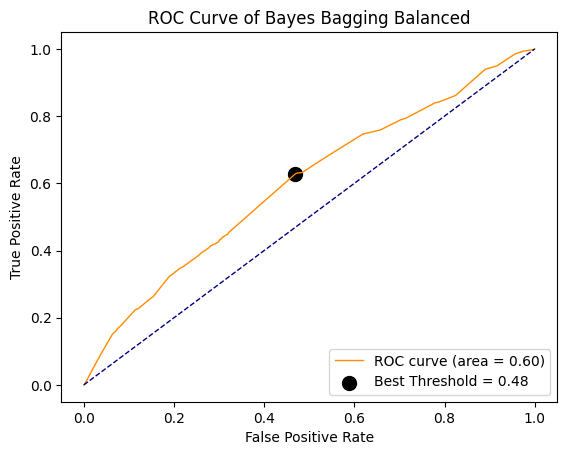

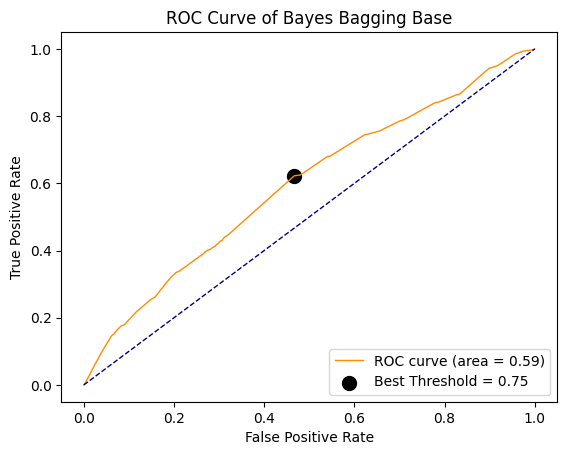

In [36]:
for idx, row in parameters.iterrows():
    model = bagging_models[ idx ]['model']
    model_name = row['Nombre']
    plot_roc_curve(model, X_test, y_test, model_name)

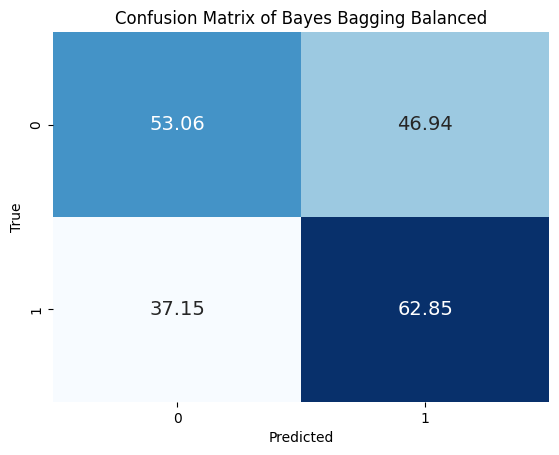

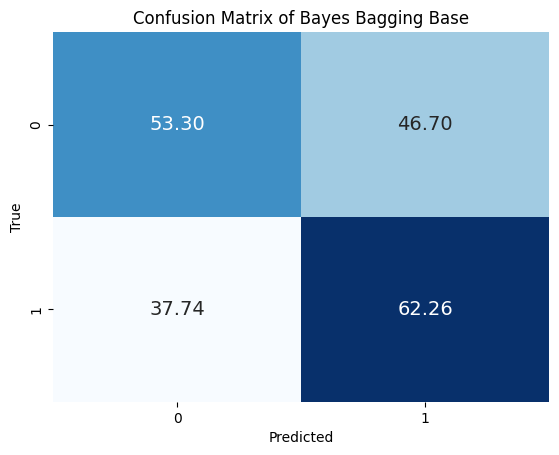

In [37]:
for idx, row in parameters.iterrows():
    model = bagging_models[ idx ]['model']
    model_name = row['Nombre']
    plot_confusion_matrix(model, X_test, y_test, model_name)

A diferencia del modelo anterior, se puede observar que la clasifición no es tan precisa para diferenciar entre ambos grupos, de forma similar a su versión antes del ensamblaje.

In [38]:
results = []

for idx, model_info in enumerate(models[10:]):
    model = model_info['model']
    name = model_info['name'] + (' Balanced' if idx % 2 == 1 else ' Base')
    cpu_time = model_info['cpu_time']
    
    evaluation = evaluate_model(model, X_test, y_test)
    evaluation['Name'] = name
    evaluation['CPU Time'] = cpu_time
    
    results.append(evaluation)

for idx, model_info in enumerate(bagging_models[:2]):
    model = model_info['model']
    name = model_info['name'] + (' Balanced' if idx % 2 == 1 else ' Base')
    cpu_time = model_info['cpu_time']
    
    evaluation = evaluate_model(model, X_test, y_test)
    evaluation['Name'] = name
    evaluation['CPU Time'] = cpu_time
    
    results.append(evaluation)

df_results = DataFrame(results)
df_results

,Precision,Recall,F1,AUC,Name,CPU Time
0,0.813008,0.620669,0.703937,0.595265,Bayesian Base,0.321328
1,0.812964,0.628483,0.708918,0.597715,Bayesian Balanced,0.077787
2,0.796006,0.579301,0.670581,0.543922,Bayesian PCA Base,0.200281
3,0.787108,0.654965,0.714982,0.541379,Bayesian PCA Balanced,0.087796
4,0.812964,0.628483,0.708918,0.598366,Bayes Bagging Base,11.425794
5,0.812324,0.622559,0.704893,0.594927,Bayes Bagging Balanced,27.536990


Es evidente que en este caso, aplicar un modelo de bagging no fue eficiente, puesto que no hubo mejoría en el score, mientras que el tiempo de entrenamiento aumentó significativamente.

### Árboles de desición

Al aplicar bagging a un modelo de árbol de desición se obtiene el modelo conocido como *Random Forest*, en este caso, se optó pur la definición "manual" para mantener un sentido de homogeneidad entre los modelos, pero es el equivalente a entrenar un modelo `RandomForestClassifier` con los espacios de búsqueda mencionados.

In [49]:
dt_bagg = {
    'name': 'Descicion Tree Bagging',
    'pipe': Pipeline([
        ('scaler', StandardScaler()),
        ('bagging', BaggingClassifier( 
                estimator = DecisionTreeClassifier(),
                random_state = 37
            ) )
    ]),
    'search_spaces': {
        'bagging__n_estimators': Integer( 5, 30 ),
        'bagging__estimator__max_depth': Integer( 4, 8 ),
        'bagging__estimator__criterion': Categorical( [ 'gini', 'entropy' ] )
    }
}

A continuación se muestran los hiperparámentros de los modelos:

In [42]:
dt_models = models[ 8:10 ]
parameters = [ 
        { 'Nombre': model_filenames[ 8 + i ] } | 
        model['model'].best_params_ | 
        { 'AUC': model['model'].best_score_, 'Tiempo de CPU': model['cpu_time'] } 
    for i, model in enumerate(dt_models) 

]
parameters = DataFrame( parameters )
parameters

,Nombre,classifier__criterion,classifier__max_depth,AUC,Tiempo de CPU
0,Descicion Tree Base,entropy,8,0.734083,79.125488
1,Descicion Tree Balanced,gini,8,0.745077,76.296319


In [44]:
knn_models = bagging_models[ 2:4 ]
parameters = [ 
        { 'Nombre': bagging_model_filenames[ 2 + i ] } | 
        model['model'].best_params_ | 
        { 'AUC': model['model'].best_score_, 'Tiempo de CPU': model['cpu_time'] } 
    for i, model in enumerate(knn_models) 

]
parameters = DataFrame( parameters )
parameters

,Nombre,bagging__estimator__criterion,bagging__estimator__max_depth,bagging__n_estimators,AUC,Tiempo de CPU
0,Descicion Tree Bagging Balanced,gini,8,50,0.713903,1990.62283
1,Descicion Tree Bagging Base,entropy,8,44,0.689414,3642.02113


Se puede ver que ambos modelos continuaron con la tendencia de usar el máximo de profundidad posible, aunque hubo un descenso considerado del puntaje. A continuación se pueden ver las curvas ROC y las matrices de confusión resultantes.

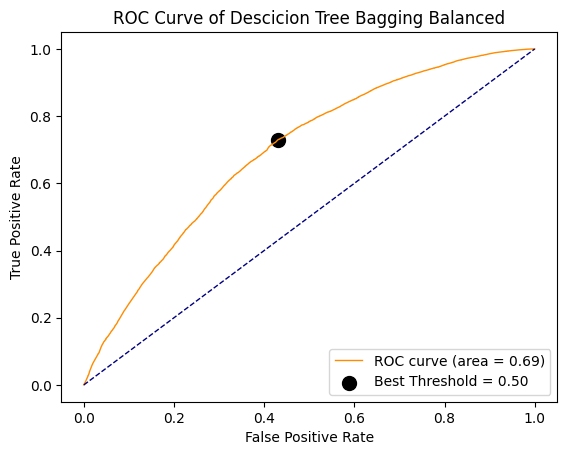

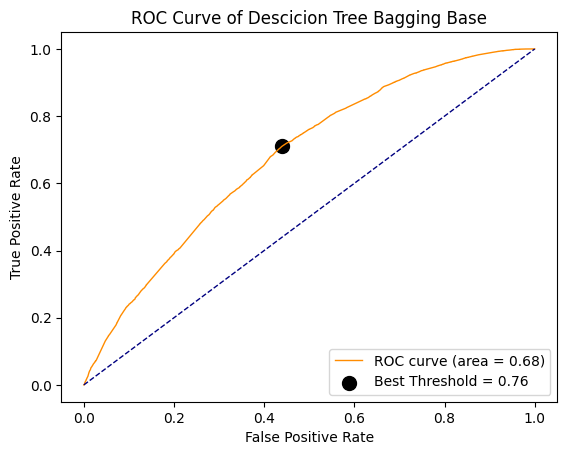

In [45]:
for idx, row in parameters.iterrows():
    model = bagging_models[ 2 + idx ]['model']
    model_name = row['Nombre']
    plot_roc_curve(model, X_test, y_test, model_name)

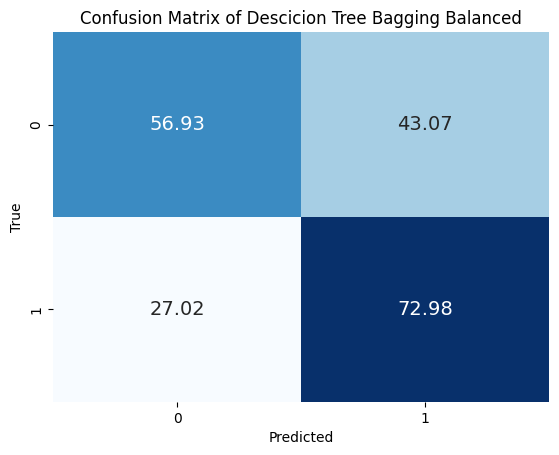

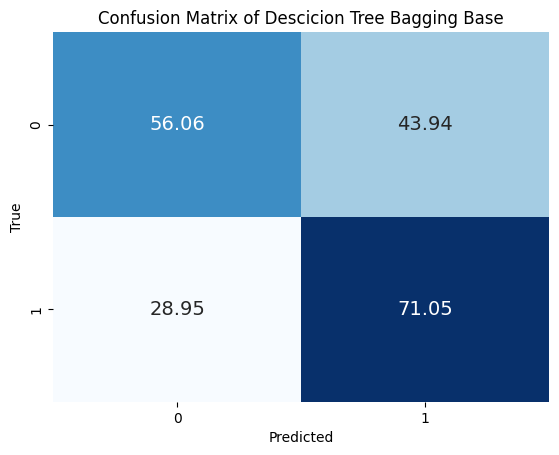

In [46]:
for idx, row in parameters.iterrows():
    model = bagging_models[ 2 + idx ]['model']
    model_name = row['Nombre']
    plot_confusion_matrix(model, X_test, y_test, model_name)

Siguiendo la tendencia, se puede ver que los modelos son mejores para clasificar las muestras con un valor de aceptado.

In [48]:
results = []

for idx, model_info in enumerate(models[8:10]):
    model = model_info['model']
    name = model_info['name'] + (' Balanced' if idx % 2 == 1 else ' Base')
    cpu_time = model_info['cpu_time']
    
    evaluation = evaluate_model(model, X_test, y_test)
    evaluation['Name'] = name
    evaluation['CPU Time'] = cpu_time
    
    results.append(evaluation)

for idx, model_info in enumerate(bagging_models[2:4]):
    model = model_info['model']
    name = model_info['name'] + (' Balanced' if idx % 2 == 1 else ' Base')
    cpu_time = model_info['cpu_time']
    
    evaluation = evaluate_model(model, X_test, y_test)
    evaluation['Name'] = name
    evaluation['CPU Time'] = cpu_time
    
    results.append(evaluation)

df_results = DataFrame(results)
df_results

,Precision,Recall,F1,AUC,Name,CPU Time
0,0.862503,0.708400,0.777893,0.727014,Descicion Tree Base,79.125488
1,0.852014,0.807895,0.829368,0.729639,Descicion Tree Balanced,76.296319
2,0.846190,0.729835,0.783717,0.694021,Descicion Tree Bagging Base,1990.622830
3,0.839988,0.710493,0.769833,0.679799,Descicion Tree Bagging Balanced,3642.021130


Podemos ver que la técnica de ensamblaje no resultó en una mejoría del puntaje del modelo, posiblemente por la partición de las muestras bootstrap generadas en el modelo.

### Regresión logística

De forma similar al caso con el modelo de clasificación bayesiana, es posible que este modelo no aumente el desempeño partiendo del score del modelo orignal.

In [ ]:
lr_bagg = {
    'name': 'Logistic Bagging',
    'pipe': Pipeline([
        ('scaler', StandardScaler()),
        ('bagging', BaggingClassifier( 
                estimator = LogisticRegression( solver='saga', max_iter=2000, penalty='l2' ),
                max_samples=0.3,
                random_state = 37
            ) )
    ]),
    'search_spaces': {
        'bagging__n_estimators': Integer( 5, 30 ),
        'bagging__estimator__C': Real(1000, 1500, prior='log-uniform')
    }
}

In [12]:
lr_models = models[ 0:4 ]
parameters = [ 
        { 'Nombre': model_filenames[ i ] } | 
        model['model'].best_params_ | 
        { 'AUC': model['model'].best_score_, 'Tiempo de CPU': model['cpu_time'] } 
    for i, model in enumerate(lr_models) 

]
parameters = DataFrame( parameters )
parameters

,Nombre,classifier__C,classifier__penalty,AUC,Tiempo de CPU
0,Logistic Base,0.080112,l1,0.645170,3484.632594
1,Logistic Balanced,153.112474,l1,0.654523,8085.255974
2,Logistic PCA Base,9953.739303,l2,0.605373,5159.598865
3,Logistic PCA Balanced,10000.000000,l2,0.618090,2013.703079


In [52]:
knn_models = bagging_models[ 8: ]
parameters = [ 
        { 'Nombre': bagging_model_filenames[ 8 + i ] } | 
        model['model'].best_params_ | 
        { 'AUC': model['model'].best_score_, 'Tiempo de CPU': model['cpu_time'] } 
    for i, model in enumerate(knn_models) 

]
parameters = DataFrame( parameters )
parameters

,Nombre,bagging__estimator__C,bagging__n_estimators,AUC,Tiempo de CPU
0,Logistic Bagging Balanced,1011.703773,20,0.653697,149858.243322
1,Logistic Bagging Base,1328.323088,11,0.644272,133984.122216


Podemos ver que la diferencia de tiempo es significativamente grandem a oesar de no haber un aumento en el puntaje dentro del entrenamiento, por lo que es facil asumir que este no es un modelo decente para el problema.

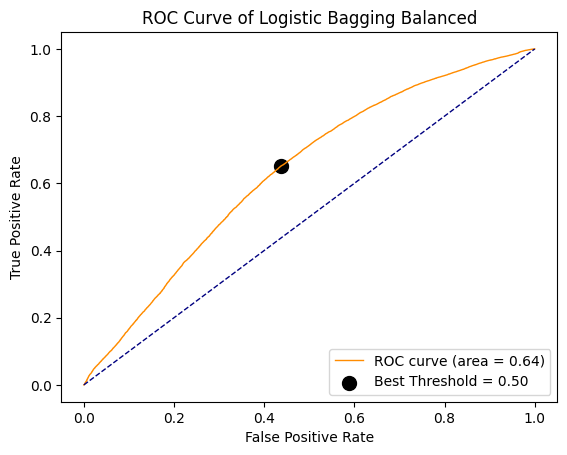

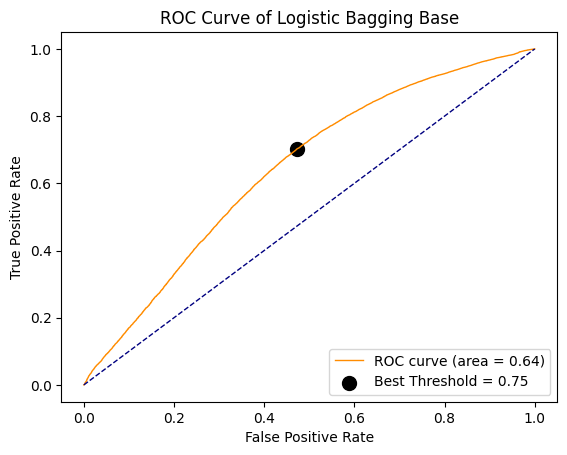

In [53]:
for idx, row in parameters.iterrows():
    model = bagging_models[ 8 + idx ]['model']
    model_name = row['Nombre']
    plot_roc_curve(model, X_test, y_test, model_name)

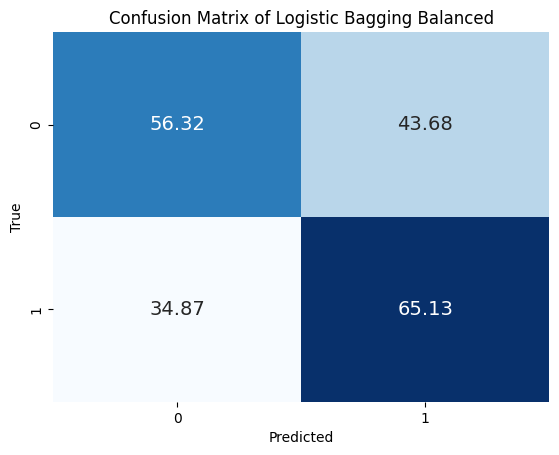

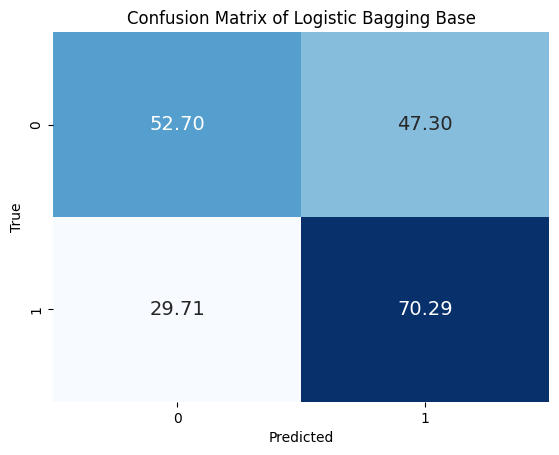

In [54]:
for idx, row in parameters.iterrows():
    model = bagging_models[ 8 + idx ]['model']
    model_name = row['Nombre']
    plot_confusion_matrix(model, X_test, y_test, model_name)

A pesar de las deficiencias, podemos observar que tiene un desempeño similar clasificando las muestras verdaderas.

In [55]:
results = []

for idx, model_info in enumerate(models[:4]):
    model = model_info['model']
    name = model_info['name'] + (' Balanced' if idx % 2 == 1 else ' Base')
    cpu_time = model_info['cpu_time']
    
    evaluation = evaluate_model(model, X_test, y_test)
    evaluation['Name'] = name
    evaluation['CPU Time'] = cpu_time
    
    results.append(evaluation)

for idx, model_info in enumerate(bagging_models[8:]):
    model = model_info['model']
    name = model_info['name'] + (' Balanced' if idx % 2 == 1 else ' Base')
    cpu_time = model_info['cpu_time']
    
    evaluation = evaluate_model(model, X_test, y_test)
    evaluation['Name'] = name
    evaluation['CPU Time'] = cpu_time
    
    results.append(evaluation)

df_results = DataFrame(results)
df_results

,Precision,Recall,F1,AUC,Name,CPU Time
0,0.827134,0.717210,0.768260,0.642395,Logistic Base,3484.632594
1,0.828319,0.703978,0.761104,0.641237,Logistic Balanced,8085.255974
2,0.818110,0.579605,0.678508,0.612687,Logistic PCA Base,5159.598865
3,0.801951,0.699354,0.747147,0.597765,Logistic PCA Balanced,2013.703079
4,0.828780,0.651285,0.729390,0.636148,Logistic Bagging Base,149858.243322
5,0.828298,0.702898,0.760463,0.643272,Logistic Bagging Balanced,133984.122216


Finalmente, podemos comparar todos los modelos entre sí. Como se mencionaba antes, el tiempo de entrenamiento es casi 50 veces mayor al promedio, tomando aproximadamente 2 dias cada uno, mientras que no se encuentra una mejora significativa en el puntaje. Aún así, supera al mejor modelo base por 0.01 puntos.

## Voting

*Voting* es un método de ensamblaje que entrena varios modelos en simultáneo y toma como resultado la categoría más predicha entre los modelos internos. De forma similar al ensamblaje anterior, se escogieron los modelos con los preprocesamientos que llevaron a un mejor desempeño, excluyendo por completo los modelos de clasificación bayesiana, puesto que como se ve anteriormente, no tiene un buen desempeño, coasa que puede generar información ruidosa para el entrenamiento.

In [7]:
with open('../../Improved/Voting/voting_list.txt', 'r') as file:
    voting_model_filenames = file.read().splitlines()

voting_models = []
for model_name in voting_model_filenames:
    model_path = os.path.join('../../Improved/Voting', f'{model_name}.pkl')
    print(f"Attempting to load model from: {model_path}")
    if os.path.exists(model_path):
        try:
            with open(model_path, 'rb') as model_file:
                model = load(model_file)
                voting_models.append(model)
                print(f"Successfully loaded model: {model_name}")
        except (UnpicklingError, EOFError, OSError, Exception) as e:
            print(f"Error loading {model_path}: {e}")
    else:
        print(f"File {model_path} does not exist.")

Attempting to load model from: ../../Improved/Voting\Voting Base.pkl
Successfully loaded model: Voting Base
Attempting to load model from: ../../Improved/Voting\Voting Balanced.pkl
Successfully loaded model: Voting Balanced


La declaración de los modelos es la siguiente:

In [6]:
est = [
    ( 'knn', 
        Pipeline(
            [
                ( 'scaling', StandardScaler() ),
                ( 'pca', PCA(0.9) ),
                ( 'classifier', KNeighborsClassifier() )
            ]
        ) 
    ),
    ( 'dt', DecisionTreeClassifier( max_depth=8 ) ),
    ( 'lr', LogisticRegression( solver='saga', penalty='l1', max_iter=1000 ) )
]

vt = {
    'name': 'Voting',
    'model': VotingClassifier( estimators=est, voting='soft' ),
    'search_spaces': {
        'knn__classifier__n_neighbors': Integer( 35, 65 ),
        'knn__classifier__weights': Categorical( [ 'uniform', 'distance' ] ),
        'dt__criterion': Categorical( [ 'gini', 'entropy' ] ),
        'lr__C': Real( 0.005, 200, prior='log-uniform' )
    }
}

En este caso, se usó una votación suave para habilitar el cálculo de probabilidades, en vez de una votación exacta de 0's y 1's, de esta manera se cuenta con información más exacta para la predicción. Los resultados de la hiperparametrización se ven a continuación:

In [31]:
parameters = [ 
        { 'Nombre': voting_model_filenames[ i ] } | 
        model['model'].best_params_ | 
        { 'AUC': model['model'].best_score_, 'Tiempo de CPU': model['cpu_time'] } 
    for i, model in enumerate(voting_models) 

]
parameters = DataFrame( parameters )
parameters

,Nombre,dt__criterion,knn__classifier__n_neighbors,knn__classifier__weights,lr__C,AUC,Tiempo de CPU
0,Voting Base,gini,35,distance,4.688043,0.750663,2168.541874
1,Voting Balanced,gini,35,distance,0.007023,0.771549,1964.780990


Podemos ver que ambos modelos tuvieron un buen desempeño en comparación a los previos. Por otro lado, es notorio que mantuvieron parámetros similares, a excepción del parámetro de regulación $C$ para la regresión logística.

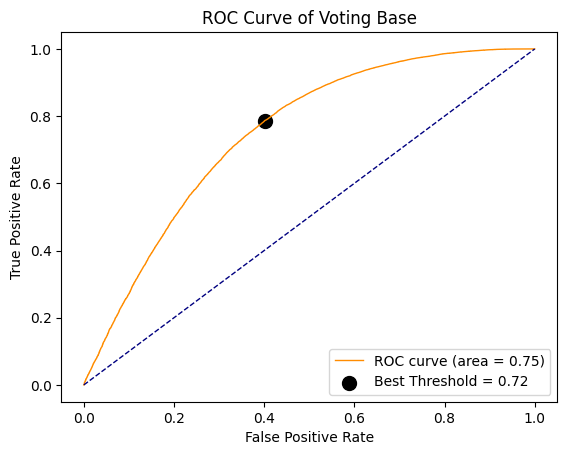

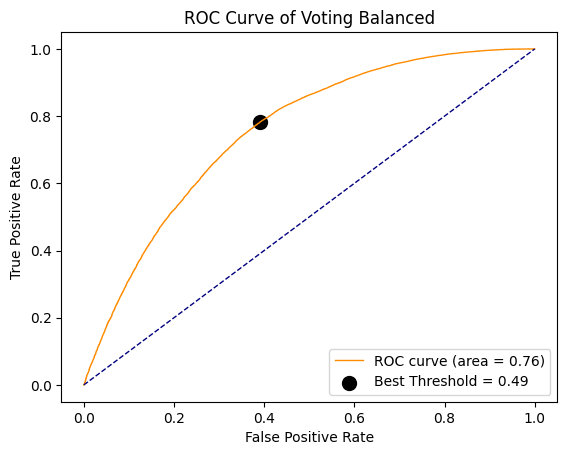

In [32]:
for idx, row in parameters.iterrows():
    model = voting_models[ idx ]['model']
    model_name = row['Nombre']
    plot_roc_curve(model, X_test, y_test, model_name)

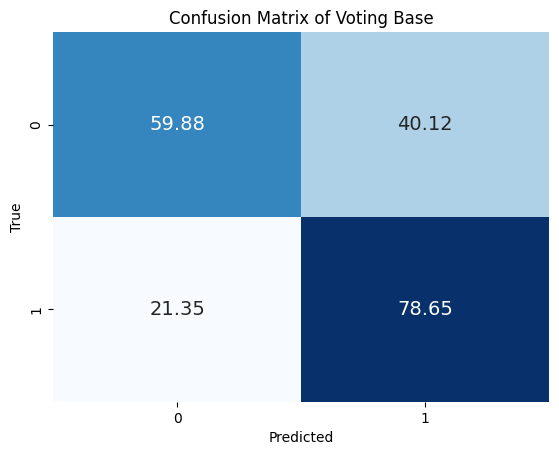

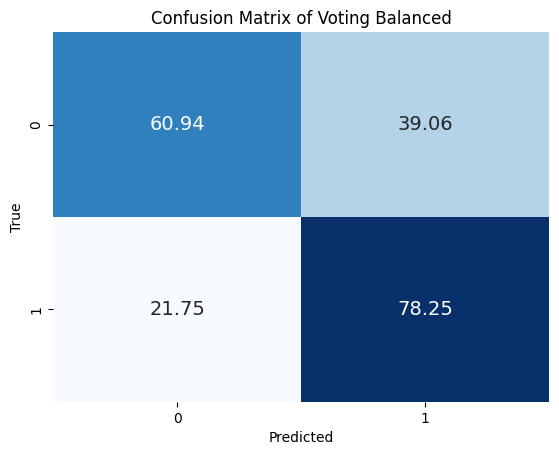

In [33]:
for idx, row in parameters.iterrows():
    model = voting_models[ idx ]['model']
    model_name = row['Nombre']
    plot_confusion_matrix(model, X_test, y_test, model_name)

Como es tendencia, ambos modelos son capaces de clasificar mejor las observaciones positivas, en este caso con una mayor diferencia que los anteriores modelos, a coste de encontrar correctamente las observaciones negativas.

## Stacking

*Stacking* es un método de ensamblaje similar a los modelos de votación, en el sentido que entrena diferentes modelos en simultáneo, con la diferencia que los resultados de estos modelos son usados posteriormente para entrenar un nuevo modelo, que puede tomar con input además los datos originales del problema. Por otro lado, el modelo final puede ser cualquier clasificador, por lo que se incluirá dentro de la búsqueda por hiperparámetros todos los modelos básicos vistos previamente.

In [5]:
with open('../../Improved/Stacking/stacking_list.txt', 'r') as file:
    stacking_model_filenames = file.read().splitlines()

stacking_models = []
for model_name in stacking_model_filenames:
    model_path = os.path.join('../../Improved/Stacking', f'{model_name}.pkl')
    print(f"Attempting to load model from: {model_path}")
    if os.path.exists(model_path):
        try:
            with open(model_path, 'rb') as model_file:
                model = load(model_file)
                stacking_models.append(model)
                print(f"Successfully loaded model: {model_name}")
        except (UnpicklingError, EOFError, OSError, Exception) as e:
            print(f"Error loading {model_path}: {e}")
    else:
        print(f"File {model_path} does not exist.")

Attempting to load model from: ../../Improved/Stacking\Stacking Base.pkl
Successfully loaded model: Stacking Base
Attempting to load model from: ../../Improved/Stacking\Stacking Balanced.pkl
Successfully loaded model: Stacking Balanced


In [ ]:
est = [
    ( 'knn', 
        Pipeline(
            [
                ( 'scaling', StandardScaler() ),
                ( 'pca', PCA(0.9) ),
                ( 'classifier', KNeighborsClassifier() )
            ]
        ) 
    ),
    ( 'dt', DecisionTreeClassifier( max_depth=8 ) ),
    ( 'lr', LogisticRegression( solver='saga', penalty='l1', max_iter=1000 ) )
]

final_est = [
    LogisticRegression( solver='lbfgs' ),
    DecisionTreeClassifier( max_depth=8 ),
    KNeighborsClassifier( n_neighbors=10 ),
    BernoulliNB()
]

stck = {
    'name': 'Stacking',
    'model': StackingClassifier( estimators=est ),
    'search_spaces': {
        'knn__classifier__n_neighbors': Integer( 35, 65 ),
        'knn__classifier__weights': Categorical( [ 'uniform', 'distance' ] ),
        'dt__criterion': Categorical( [ 'gini', 'entropy' ] ),
        'lr__C': Real( 0.005, 200, prior='log-uniform' ),
        'final_estimator': Categorical(final_est),
        'passthrough':  Categorical( [ True, False ] )
    }
}

El parámetro `passthrough=True` indica la inclusión de los datos originales junto con los resultados de las clasificaciones. A continuación se pueden ver los resultados de la búsqueda. A su vez, los parámetros se centran en los resultados previos de las otras hiperparametrizaciones.

In [34]:
parameters = [ 
        { 'Nombre': stacking_model_filenames[ i ] } | 
        model['model'].best_params_ | 
        { 'AUC': model['model'].best_score_, 'Tiempo de CPU': model['cpu_time'] } 
    for i, model in enumerate(stacking_models) 

]
parameters = DataFrame( parameters )
parameters

,Nombre,dt__criterion,final_estimator,knn__classifier__n_neighbors,knn__classifier__weights,lr__C,passthrough,AUC,Tiempo de CPU
0,Stacking Base,gini,DecisionTreeClassifier(max_depth=8),35,distance,0.005000,True,0.762499,21771.173154
1,Stacking Balanced,gini,LogisticRegression(),35,distance,169.695782,False,0.773738,8230.958139


Podemos evidenciar que ambos modelos tuvieron un mejor desempeño al establecer el mínimo posible de vecinos, mientras que tuvieron diferencias entre el término de regulación $C$. Otro cambio notorio es el estimador final; en el caso del modelo con datos balanceados, optó por una regresión logística sin la inclusión de los datos originales, por otro lado, el modelo con los datos originales usó un árbol de desición con la inclusión de la base de datos, por lo que es esperable la diferencia entre ambos puntajes. La diferencia de tiempo se puede deber a que los datos base tienen más datos, o bien al entrenamiento del modelo adicional con los datos originales.

A continuación se pueden ver los gráficos de curvas ROC y matrices de confusión:

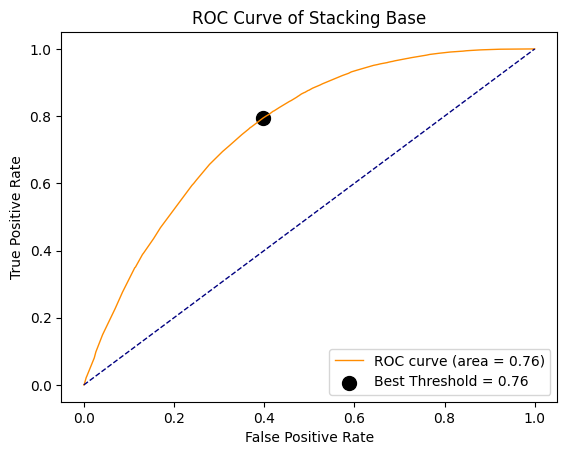

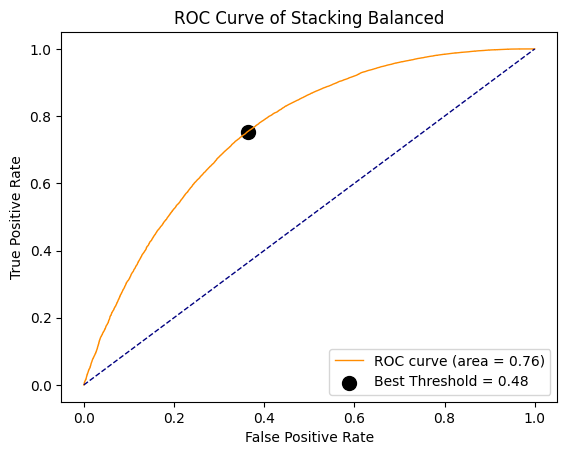

In [36]:
for idx, row in parameters.iterrows():
    model = stacking_models[ idx ]['model']
    model_name = row['Nombre']
    plot_roc_curve(model, X_test, y_test, model_name)

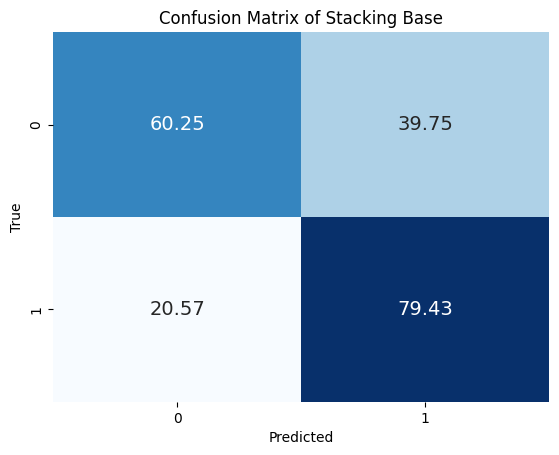

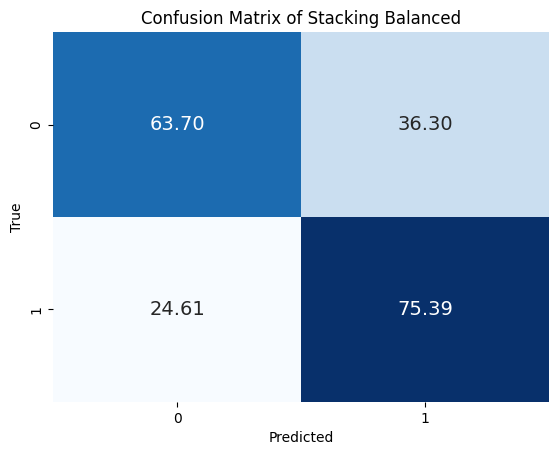

In [37]:
for idx, row in parameters.iterrows():
    model = stacking_models[ idx ]['model']
    model_name = row['Nombre']
    plot_confusion_matrix(model, X_test, y_test, model_name)

Es evidente que se repiten los resultados mencionados previamente, siendo capaz de clasificar mejor las observaciones positivas que las negativas.

## Comparacion de modelos

Teniendo todo esto en cuenta, podemos ver la comparación de todos los modelos mencionados en el capítulo, junto con los mejore modelos del capítulo pasado.

In [7]:
# Dados problemas del kernel y las versiones de las librerías usadas, se guardaron ciertos resultados de los modelos.
with open( 'failsafe.pkl', 'rb' ) as f:
    backup_predictions, backup_df_results = load(f)
    
results = []
selected_models = models[ 4:8 ] + bagging_models
for idx, model_info in enumerate(selected_models):
    model = model_info['model']
    name = model_info['name'] + (' Balanced' if idx % 2 == 1 else ' Base')
    cpu_time = model_info['cpu_time']
    
    evaluation = evaluate_model(model, X_test, y_test)
    evaluation['Name'] = name
    evaluation['CPU Time'] = cpu_time
    
    results.append(evaluation)

df_results = DataFrame(results)
df_results = concat( [ df_results, backup_df_results ], axis = 0 )
df_results.index = [ i for i in range( len(df_results) ) ]
df_results

,Precision,Recall,F1,AUC,Name,CPU Time
0,0.860359,0.754021,0.803688,0.739825,KNN Base,1925.500179
1,0.859890,0.747051,0.799509,0.735952,KNN Balanced,942.796789
2,0.861501,0.750122,0.801963,0.740496,KNN PCA Base,437.227390
3,0.864612,0.724856,0.788590,0.736895,KNN PCA Balanced,359.124776
4,0.812964,0.628483,0.708918,0.598366,Bayes Bagging Base,11.425794
5,0.812324,0.622559,0.704893,0.594927,Bayes Bagging Balanced,27.536990
6,0.846190,0.729835,0.783717,0.694021,Descicion Tree Bagging Base,1990.622830
7,0.839988,0.710493,0.769833,0.679799,Descicion Tree Bagging Balanced,3642.021130
8,0.861577,0.742612,0.797683,0.740347,KNN Bagging Base,445.296643
9,0.862165,0.754528,0.804763,0.743366,KNN Bagging Balanced,1449.879107


Podemos ver a continuación el mejor modelo entre todos:

In [9]:
max_auc_index = df_results['AUC'].idxmax()
row_with_max_auc = df_results.loc[max_auc_index]
DataFrame(row_with_max_auc).T

,Precision,Recall,F1,AUC,Name,CPU Time
16,0.866443,0.794275,0.828791,0.761329,Stacking Base,21771.173154


A pesar del alto tiempo de entrenamiento, podemos ver que obtuvo resultados decentes, tanto para la precisión, como para el recall, por lo que es bueno clasificando observaciones para ambas categorías. Por otro lado, es uno de los modelos que más tiempo tomó para su entrenamiento. Un modelo con un rendimiento similar, pero con un tiempo de entrenamiento 3 veces menor, es su versión entrenada con los datos balanceados, que únicamente pierde 0.05 puntos en el AUC, a costa de aumentar la diferencia entre la precisión y el recall. Finalmente, se escoje como modelo para el problema el modelo de stacking con los datos origales, dado que es el que mayor puntaje tiene, además de tener un buen balance entre precisión y recall.

Finalmente podemos ver las predicciones de cada modelo en esta gráfica:

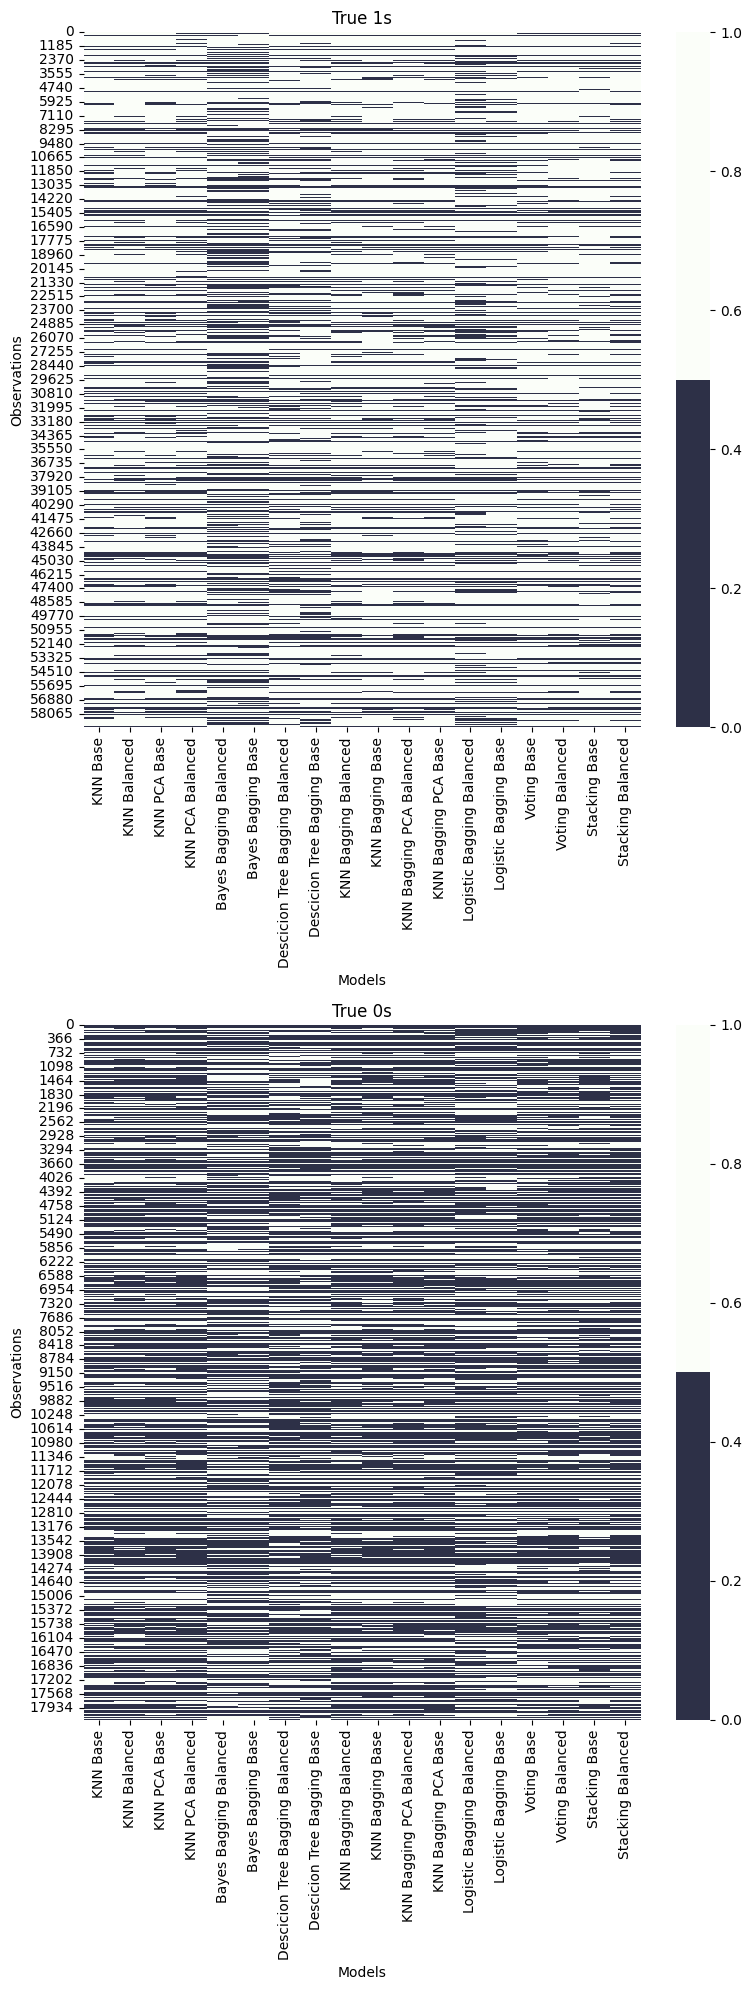

In [22]:
selected_model_names = model_filenames[4:8] + bagging_model_filenames 
plot_predictions( [ model['model'] for model in selected_models ], X_test, y_test, selected_model_names + list(backup_df_results.T.loc['Name']), figsize = (8,20), backup=backup_predictions )

Es evidente cómo, para la mayoría de modelos, son capaces de predecir correctamente las observaciones positivas más claramente que las negativas. 